# Baseline models for ticket classification

This notebook trains simple baseline models for the customer support ticket classification task. The goals are:

1. Establish a very simple majority-class baseline.
2. Train a TF-IDF + Logistic Regression baseline.
3. Produce clear evaluation metrics and confusion matrices.



## Data loading and train/test split

This section loads the cleaned tickets dataset and prepares features and labels for modeling. We perform two stratified splits to produce training, validation and test sets while preserving the label distribution across splits.

Step-by-step:
1. Read the cleaned CSV into a DataFrame `df` and inspect shape and examples.
2. Compute `class_dist = df['label'].value_counts(normalize=True)` to inspect label imbalance (used later for baseline interpretation).
3. Split off a held-out test set (20%) using `train_test_split(..., stratify=y, random_state=42)` so the test distribution matches the full dataset.
4. From the remaining 80% create a validation set (25% of the remaining -> 20% of original) with stratification and the same random seed. The validation set is used for model selection and hyperparameter tuning, and the test set remains untouched until final evaluation.

Why stratify? For imbalanced multi-class problems, stratified splits ensure minority classes are present in each split so evaluation metrics are meaningful. The `random_state` is set for reproducibility.

In [63]:
# Standard imports used throughout the notebook
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Load cleaned dataset (relative path)
df = pd.read_csv('../data/clean/clean_tickets.csv')
print(f'Shape of dataframe: {df.shape}')
df.head()



Shape of dataframe: (472, 4)


,text,label,ticket_id,agent_name
0,Where can I find API rate limits documentation?,other,1000,Dana
1,Can I migrate data from Freshdesk?,other,1001,Bob
2,Cannot update billing address; page keeps relo...,billing,1002,Charlie
3,Looking for a product roadmap or upcoming feat...,other,1003,Dana
4,Dark mode toggled but UI stays light.,technical,1004,Alice


In [64]:
# Compute class distribution for downstream checks and baselines
class_dist = df['label'].value_counts(normalize=True)
print('\nClass distribution:')
print(class_dist)


Class distribution:
label
other        0.264831
technical    0.252119
account      0.243644
billing      0.239407
Name: proportion, dtype: float64


In [65]:
# Remove noisy duplicates: keep only the first occurrence of each (text, label) pair
before_dedup = len(df)
df = df.drop_duplicates(subset=["text", "label"]).reset_index(drop=True)
after_dedup = len(df)
print(f"Removed {before_dedup - after_dedup} noisy duplicate rows (exact text+label matches)")
print(f"Dataset now has {after_dedup} rows (was {before_dedup})")

Removed 331 noisy duplicate rows (exact text+label matches)
Dataset now has 141 rows (was 472)


### Handling Duplicate Text Entries
Some support tickets in the dataset have identical text. While some duplicates may be legitimate (e.g., repeated issues), others may be noise or data entry errors. To improve model generalization, we filter out noisy duplicates while preserving meaningful ones.

**Approach:**
- Remove exact duplicate rows based on both `text` and `label` (likely noise or accidental repeats).
- Retain tickets with the same `text` but different `label` (could be legitimate multi-label or annotation disagreement).
- This ensures the model is not biased by repeated identical samples, but preserves potentially meaningful edge cases.

The following code cell implements this filtering before splitting the data.

In [66]:
class_dist = df['label'].value_counts(normalize=True)
print('\nLabel distribution:')
for label, prop in class_dist.items():
    print(f'{label}: {prop:.3f}')

# Split into features and labels
X = df['text']
y = df['label']

# First split: separate test set
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, 
    test_size=0.2,
    stratify=y,
    random_state=42
)

# Second split: create validation set from remaining data
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.25,  # 0.25 x 0.8 = 0.2 of original data
    stratify=y_temp,
    random_state=42
)

print('\nData split sizes:')
print(f'Training set: {len(X_train)} samples')
print(f'Validation set: {len(X_val)} samples')
print(f'Test set: {len(X_test)} samples')


Label distribution:
billing: 0.270
technical: 0.270
other: 0.234
account: 0.227

Data split sizes:
Training set: 84 samples
Validation set: 28 samples
Test set: 29 samples


## Majority-class baseline

This section builds a trivial baseline that always predicts the most frequent class observed in the training data. We use this to establish the performance floor any meaningful model must beat.

Step-by-step:
1. Build a `DummyClassifier(strategy='most_frequent')`. The model ignores input features and always returns the majority label.
2. Fit on the training set and compute 5-fold cross-validated F1 (weighted) on training to inspect variance.
3. Evaluate on the validation set and compute accuracy, weighted F1, and a classification report. These metrics provide baseline numbers to compare with the TF-IDF+LogReg model.
4. Save a confusion matrix to `../artifacts/cm_majority.png` for visual inspection of which classes are most/least predicted.

Notes:
- Because this model ignores features it is extremely fast to fit and is only useful as a reference point. If the dataset is highly imbalanced, the majority baseline may get a deceptively high accuracy — prefer weighted F1 for balanced reporting.

Baseline 5-fold CV scores: [0.08963585 0.08963585 0.13368984 0.08963585 0.1       ]
Average CV F1: 0.1005 (+/- 0.0341)

Majority baseline metrics (validation set):
  Accuracy: 0.2500
  Weighted F1: 0.1000

Classification report (majority baseline):
              precision    recall  f1-score   support

     account       0.00      0.00      0.00         7
     billing       0.25      1.00      0.40         7
       other       0.00      0.00      0.00         7
   technical       0.00      0.00      0.00         7

    accuracy                           0.25        28
   macro avg       0.06      0.25      0.10        28
weighted avg       0.06      0.25      0.10        28



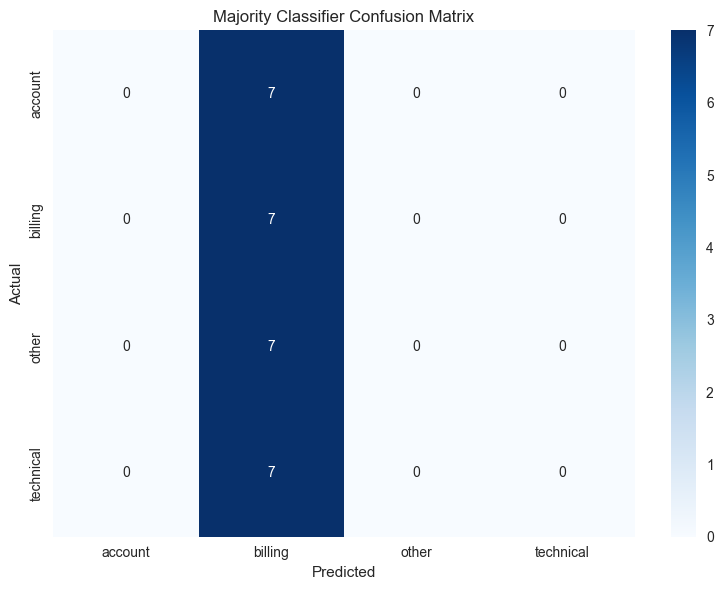

In [67]:
# Create pipeline for baseline model (no vectorizer needed for DummyClassifier)
# DummyClassifier does not use features; keep pipeline minimal to avoid extra computation
baseline_pipe = Pipeline([
    ('classifier', DummyClassifier(strategy='most_frequent')),
])

# Fit and evaluate baseline
baseline_pipe.fit(X_train, y_train)

# Cross-validation scores for baseline
baseline_cv_scores = cross_val_score(
    baseline_pipe, X_train, y_train,
    cv=5, scoring='f1_weighted'
)

print("Baseline 5-fold CV scores:", baseline_cv_scores)
print(f"Average CV F1: {baseline_cv_scores.mean():.4f} (+/- {baseline_cv_scores.std() * 2:.4f})")

# Predict on validation set
y_pred_majority = baseline_pipe.predict(X_val)

# Compute evaluation metrics
acc_majority = accuracy_score(y_val, y_pred_majority)
f1_majority = f1_score(y_val, y_pred_majority, average='weighted')
cm_majority = confusion_matrix(y_val, y_pred_majority)

print('\nMajority baseline metrics (validation set):')
print(f'  Accuracy: {acc_majority:.4f}')
print(f'  Weighted F1: {f1_majority:.4f}')
print('\nClassification report (majority baseline):')
print(classification_report(y_val, y_pred_majority, zero_division=0))

# Save confusion matrix figure to artifacts for MLflow
import os
os.makedirs('../artifacts', exist_ok=True)
plt.figure(figsize=(8,6))
sns.heatmap(cm_majority, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(y.unique()), yticklabels=sorted(y.unique()))
plt.title('Majority Classifier Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
majority_cm_path = '../artifacts/cm_majority.png'
plt.savefig(majority_cm_path)
plt.show()

## TF-IDF vectorization

This section transforms raw ticket text into numeric features using TF-IDF. TF-IDF weights tokens by term frequency scaled by inverse document frequency, which helps reduce the impact of common words.

Step-by-step:
1. Instantiate `TfidfVectorizer` with a constrained vocabulary (max_features=5000) and n-grams up to bigrams to capture short phrases.
2. Use `stop_words='english'`, `min_df=2`, and `max_df=0.95` to reduce noise and extremely rare terms.
3. Fit the vectorizer only inside the training pipeline so no information from validation or test leaks into the model training.
4. Vectorization is wrapped in a scikit-learn `Pipeline` together with `LogisticRegression` so hyperparameter search and cross-validation behave correctly.

Notes:
- Limiting `max_features` speeds up training and reduces memory usage. If you have more compute or want to explore richer representations, consider increasing it or using pretrained embeddings.

In [68]:
# Create pipeline for TF-IDF + LogReg
model_pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(
        max_features=5000,
        ngram_range=(1, 2),
        stop_words='english',
        min_df=2,
        max_df=0.95
    )),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# Define parameter grid
param_grid = {
    'classifier__C': [0.1, 1.0, 10.0],
    'classifier__class_weight': [None, 'balanced'],
    'vectorizer__max_features': [3000, 5000],
    'vectorizer__ngram_range': [(1, 1), (1, 2)]
}

# Perform cross-validated grid search on training data
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(
    model_pipe,
    param_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

# Fit on training data
grid_search.fit(X_train, y_train)

print(f'\nBest parameters found: {grid_search.best_params_}')
print(f'Best cross-validation score: {grid_search.best_score_:.4f}')

Fitting 5 folds for each of 24 candidates, totalling 120 fits

Best parameters found: {'classifier__C': 10.0, 'classifier__class_weight': None, 'vectorizer__max_features': 3000, 'vectorizer__ngram_range': (1, 1)}
Best cross-validation score: 0.7742

Best parameters found: {'classifier__C': 10.0, 'classifier__class_weight': None, 'vectorizer__max_features': 3000, 'vectorizer__ngram_range': (1, 1)}
Best cross-validation score: 0.7742


In [69]:
# Verify data split integrity
print("Checking for data leakage...")
print("\nSample overlap between splits:")
print(f"Train-Val overlap: {len(set(X_train.index) & set(X_val.index))}")
print(f"Train-Test overlap: {len(set(X_train.index) & set(X_test.index))}")
print(f"Val-Test overlap: {len(set(X_val.index) & set(X_test.index))}")

# Check feature independence
print("\nVerifying TF-IDF computation independence:")
# Create two separate vectorizers with same parameters
vec1 = TfidfVectorizer(max_features=5000)
vec2 = TfidfVectorizer(max_features=5000)

# Fit and transform on train vs test
X_train_vec1 = vec1.fit_transform(X_train)
X_test_vec2 = vec2.fit_transform(X_test)

# Compare vocabulary sizes
print(f"Train vocab size: {len(vec1.vocabulary_)}")
print(f"Test vocab size: {len(vec2.vocabulary_)}")
print(f"Vocabulary overlap: {len(set(vec1.vocabulary_.keys()) & set(vec2.vocabulary_.keys()))}")

# Print unique label counts in each split
print("\nLabel distribution in splits:")
print("\nTrain set:")
print(y_train.value_counts(normalize=True))
print("\nValidation set:")
print(y_val.value_counts(normalize=True))
print("\nTest set:")
print(y_test.value_counts(normalize=True))

Checking for data leakage...

Sample overlap between splits:
Train-Val overlap: 0
Train-Test overlap: 0
Val-Test overlap: 0

Verifying TF-IDF computation independence:
Train vocab size: 223
Test vocab size: 140
Vocabulary overlap: 129

Label distribution in splits:

Train set:
label
billing      0.27381
technical    0.27381
other        0.22619
account      0.22619
Name: proportion, dtype: float64

Validation set:
label
other        0.25
billing      0.25
account      0.25
technical    0.25
Name: proportion, dtype: float64

Test set:
label
technical    0.275862
billing      0.275862
other        0.241379
account      0.206897
Name: proportion, dtype: float64


In [70]:
# Leakage diagnostics: ensure no overlapping samples and check duplicate texts
print("Checking for duplicate text entries in the full dataset:")
num_duplicates = df['text'].duplicated().sum()
print(f"Number of duplicate text rows in dataset: {num_duplicates}")

# Check overlap between splits using indices
train_idx = set(X_train.index)
val_idx = set(X_val.index)
test_idx = set(X_test.index)

print('\nOverlap between splits (should be 0):')
print(f'Train-Val overlap: {len(train_idx & val_idx)}')
print(f'Train-Test overlap: {len(train_idx & test_idx)}')
print(f'Val-Test overlap: {len(val_idx & test_idx)}')

# Sanity: check sample counts again
print('\nSplit sizes:')
print(f'Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}')

Checking for duplicate text entries in the full dataset:
Number of duplicate text rows in dataset: 0

Overlap between splits (should be 0):
Train-Val overlap: 0
Train-Test overlap: 0
Val-Test overlap: 0

Split sizes:
Train: 84, Val: 28, Test: 29


## TF-IDF + Logistic Regression baseline

This section trains a regularized Logistic Regression classifier on TF-IDF features. Logistic Regression is a strong, interpretable baseline for text classification tasks.

Step-by-step:
1. Build a scikit-learn `Pipeline` combining `TfidfVectorizer` and `LogisticRegression(random_state=42)`.
2. Define the hyperparameter grid to search over regularization strength `C`, `class_weight`, and vectorizer settings (`max_features`, `ngram_range`).
3. Use `GridSearchCV` (cv=5, scoring='f1_weighted') to find the best hyperparameters based on weighted F1. `n_jobs=-1` parallelizes the search.
4. Inspect `grid_search.best_params_` and `grid_search.best_score_` to understand the selected model and cross-validated performance.
5. Generate learning curves to diagnose underfitting/overfitting and then evaluate the best model on validation and held-out test sets. Save confusion matrices and metrics to `../artifacts`.
6. Save supporting artifacts for reproducibility: vectorizer vocabulary, label mapping, environment info, and the trained model (joblib). These are later logged to MLflow.

Notes:
- Weighted F1 is used for model selection due to class imbalance. If you want to optimize a specific class or macro-average, change the scoring accordingly.
- Grid search on text models can be slow. Consider RandomizedSearchCV if you expand the hyperparameter space.

Generating learning curves (this may take a moment)...


c:\Users\EMMANUEL\projects\Thrive_Internship_ML_A\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
4 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\EMMANUEL\projects\Thrive_Internship_ML_A\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\EMMANUEL\projects\Thrive_Internship_ML_A\.venv\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\EMMANUEL\pr

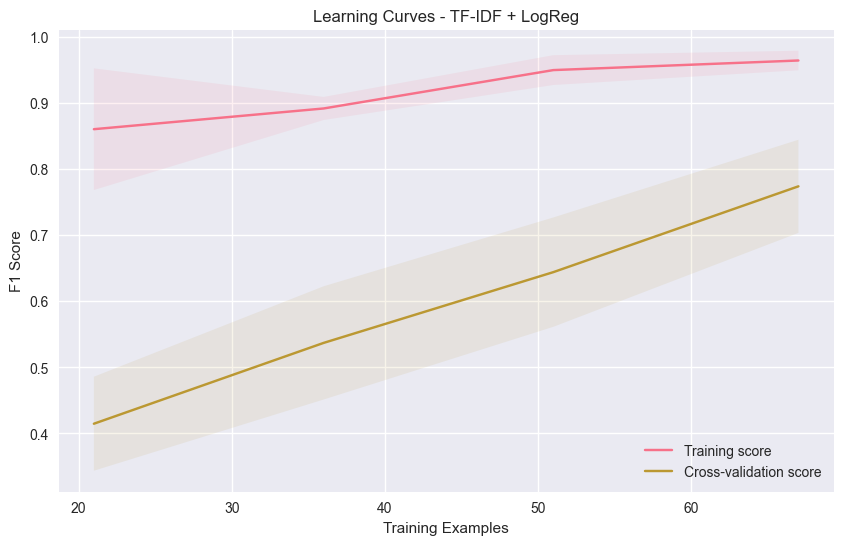


Validation Set Performance:
              precision    recall  f1-score   support

     account       1.00      0.86      0.92         7
     billing       1.00      1.00      1.00         7
       other       1.00      0.86      0.92         7
   technical       0.78      1.00      0.88         7

    accuracy                           0.93        28
   macro avg       0.94      0.93      0.93        28
weighted avg       0.94      0.93      0.93        28


Test Set Performance:
              precision    recall  f1-score   support

     account       1.00      0.83      0.91         6
     billing       1.00      1.00      1.00         8
       other       1.00      0.86      0.92         7
   technical       0.80      1.00      0.89         8

    accuracy                           0.93        29
   macro avg       0.95      0.92      0.93        29
weighted avg       0.94      0.93      0.93        29



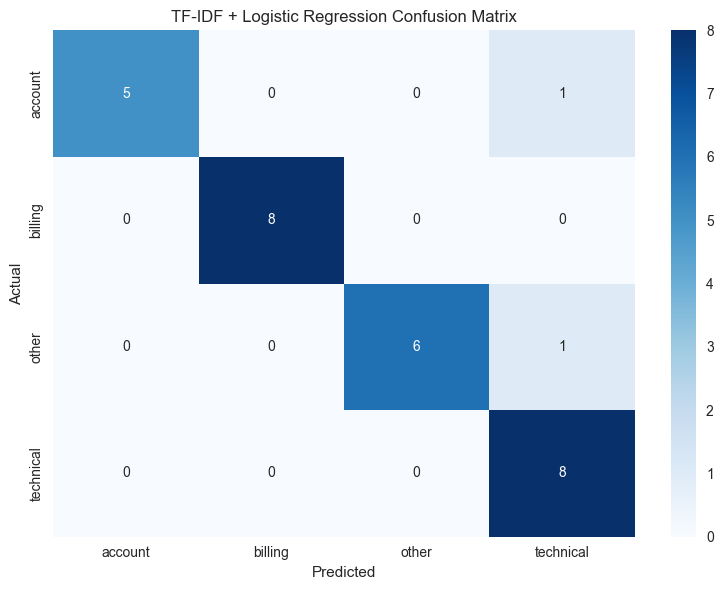


Model Performance Comparison:


,Metric,Validation,Test
0,Accuracy,0.9286,0.931
1,Weighted F1,0.9303,0.932


In [71]:
# Get best model
best_model = grid_search.best_estimator_

# Plot learning curves to check for overfitting
def plot_learning_curves(estimator, title):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X_train, y_train,
        train_sizes=np.linspace(0.1, 1.0, 5),
        cv=5, scoring='f1_weighted', n_jobs=-1
    )
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training score')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
    plt.plot(train_sizes, val_mean, label='Cross-validation score')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1)
    
    plt.xlabel('Training Examples')
    plt.ylabel('F1 Score')
    plt.title(f'Learning Curves - {title}')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

print("Generating learning curves (this may take a moment)...")
plot_learning_curves(best_model, 'TF-IDF + LogReg')

# Evaluate on validation set
y_pred_val = best_model.predict(X_val)
print('\nValidation Set Performance:')
print(classification_report(y_val, y_pred_val))

# Final evaluation on test set
y_pred_test = best_model.predict(X_test)
print('\nTest Set Performance:')
print(classification_report(y_test, y_pred_test))

# Store metrics for final comparison
acc_logreg = accuracy_score(y_test, y_pred_test)
f1_logreg = f1_score(y_test, y_pred_test, average='weighted')
cm_logreg = confusion_matrix(y_test, y_pred_test)

# Save confusion matrix for logreg
import os
os.makedirs('../artifacts', exist_ok=True)
plt.figure(figsize=(8,6))
sns.heatmap(cm_logreg, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(y.unique()), yticklabels=sorted(y.unique()))
plt.title('TF-IDF + Logistic Regression Confusion Matrix') 
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
logreg_cm_path = '../artifacts/cm_logreg.png'
plt.savefig(logreg_cm_path)
plt.show()

# Save the fitted vectorizer vocabulary and label mapping for later inference
try:
    # The vectorizer is inside the pipeline: extract it
    vectorizer = best_model.named_steps['vectorizer'] if hasattr(best_model, 'named_steps') else None
    if vectorizer is not None:
        vocab_path = '../artifacts/vectorizer_vocab.json'
        try:
            # Convert keys and values to JSON-safe Python types (str, int)
            safe_vocab = {str(k): int(v) for k, v in vectorizer.vocabulary_.items()}
        except Exception:
            safe_vocab = {}
            for k, v in vectorizer.vocabulary_.items():
                try:
                    safe_vocab[str(k)] = int(v)
                except Exception:
                    # Keep original if conversion fails
                    safe_vocab[str(k)] = v
        with open(vocab_path, 'w', encoding='utf-8') as vf:
            import json as _json
            _json.dump(safe_vocab, vf, ensure_ascii=False, indent=2)
    else:
        print("Warning: vectorizer not found in best_model; skipping vocab save.")
except Exception as e:
    print(f"Warning: could not save vectorizer vocabulary: {e}")

# Save label mapping
try:
    labels = sorted(y.unique())
    label_map_path = '../artifacts/label_map.json'
    with open(label_map_path, 'w', encoding='utf-8') as lf:
        import json as _json
        _json.dump(labels, lf, ensure_ascii=False, indent=2)
except Exception as e:
    print(f"Warning: could not save label mapping: {e}")

# Save environment/package versions for reproducibility
try:
    import pkg_resources, platform, sys
    pkgs = {p.key: p.version for p in pkg_resources.working_set if p.key in ['numpy','pandas','scikit-learn','mlflow','seaborn','matplotlib']}
    env_info = {"python_version": sys.version, "platform": platform.platform(), "packages": pkgs}
    env_path = '../artifacts/env_info.json'
    with open(env_path, 'w', encoding='utf-8') as ef:
        import json as _json
        _json.dump(env_info, ef, indent=2)
except Exception as e:
    print(f"Warning: could not write environment info: {e}")

# Save model locally with joblib as a fallback
try:
    import joblib
    model_local_path = '../artifacts/tfidf_logreg_model.joblib'
    joblib.dump(best_model, model_local_path)
except Exception as e:
    print(f"Warning: could not save model with joblib: {e}")

# Compare validation and test performance
print('\nModel Performance Comparison:')
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Weighted F1'],
    'Validation': [
        accuracy_score(y_val, y_pred_val),
        f1_score(y_val, y_pred_val, average='weighted')
    ],
    'Test': [
        accuracy_score(y_test, y_pred_test),
        f1_score(y_test, y_pred_test, average='weighted')
    ]
})
display(metrics_df.round(4))

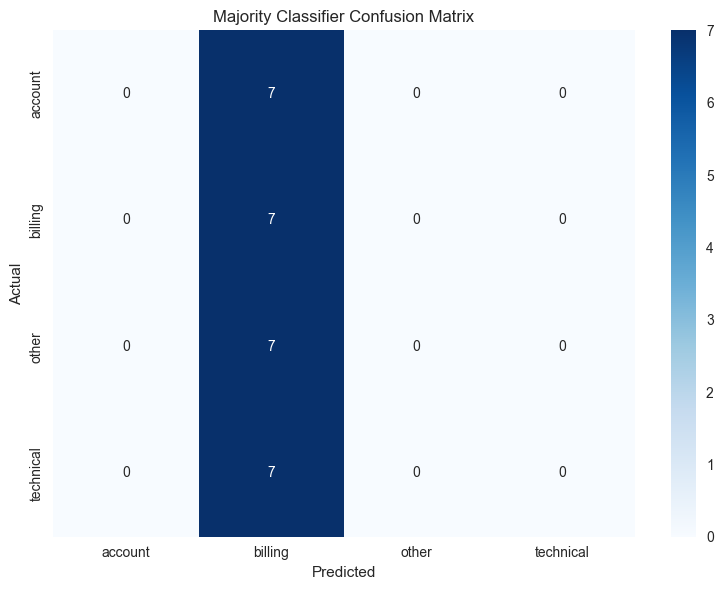

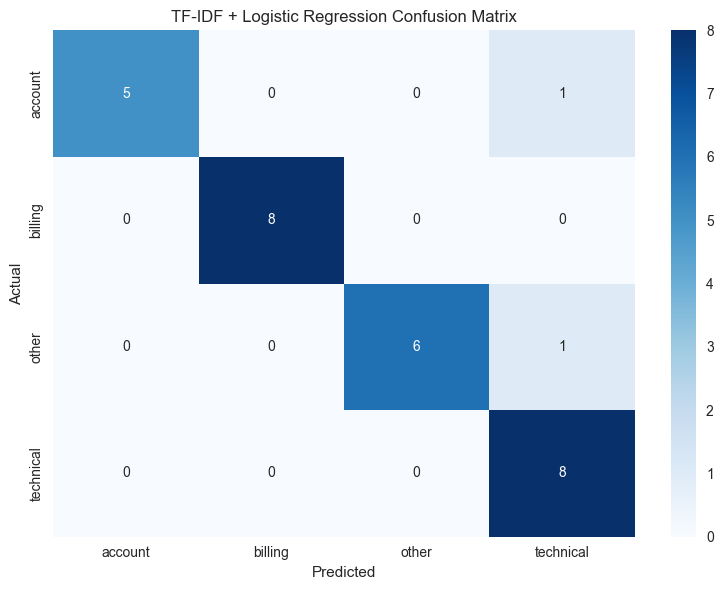


Summary of baseline results:


,model,accuracy,weighted_f1
0,majority,0.250000,0.100000
1,tfidf_logreg,0.931034,0.931972


In [72]:
def plot_confusion(cm, classes, title, figsize=(8,6)):
    """Plot a confusion matrix with class labels.
    Args:
        cm: confusion matrix (2D array)
        classes: list of class labels in the order used by the matrix
        title: plot title
    """
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

# Determine class order from the training labels to keep axes consistent
classes = sorted(y.unique())
plot_confusion(cm_majority, classes, 'Majority Classifier Confusion Matrix')
plot_confusion(cm_logreg, classes, 'TF-IDF + Logistic Regression Confusion Matrix')

# Save plots if not already saved
import os
os.makedirs('../artifacts', exist_ok=True)
if not os.path.exists('../artifacts/cm_majority.png'):
    plt.figure(figsize=(8,6))
    sns.heatmap(cm_majority, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title('Majority Classifier Confusion Matrix')
    plt.tight_layout()
    plt.savefig('../artifacts/cm_majority.png')
    plt.close()

if not os.path.exists('../artifacts/cm_logreg.png'):
    plt.figure(figsize=(8,6))
    sns.heatmap(cm_logreg, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title('TF-IDF + Logistic Regression Confusion Matrix')
    plt.tight_layout()
    plt.savefig('../artifacts/cm_logreg.png')
    plt.close()

# Summary table comparing baselines
results = pd.DataFrame({
    'model': ['majority', 'tfidf_logreg'],
    'accuracy': [acc_majority, acc_logreg],
    'weighted_f1': [f1_majority, f1_logreg]
})
print('\nSummary of baseline results:')
display(results)

MLflow integration

This section demonstrates how we track experiments and artifacts using MLflow. The goals are:
- Record parameter choices and cross-validation score for reproducibility.
- Save evaluation metrics and confusion matrices as artifacts.
- Save the trained model object so it can be loaded later for inference or deployment.

Key behaviors implemented:
1. Explicitly set a file-based MLflow tracking URI to avoid unexpected defaults and to make runs visible under `notebooks/mlruns`.
2. Use a safe run starter that does not forcibly end active runs; nested runs are used to separate baseline experiments.
3. Log model metadata (best params) and metrics (accuracy, weighted F1) and log saved artifacts defensively (only if file exists).
4. Log the trained sklearn model using `mlflow.sklearn.log_model` for downstream reproducibility and serving.

Notes and tips:
- If MLflow UI is desired locally, run `mlflow ui --backend-store-uri file:///<path-to-notebooks>/mlruns` and navigate to http://localhost:5000.
- Ensure the `mlruns` directory exists and is writable by your process; the notebook attempts to create it automatically but you can also create it manually.
- When sharing experiments, attach the `env_info.json` artifact so others can replicate the environment.

In [73]:
import mlflow
import os

mlflow.set_experiment("baseline_models")

def safe_start_run(run_name, nested=False):
    if mlflow.active_run() is not None:
        mlflow.end_run()
    return mlflow.start_run(run_name=run_name, nested=nested)

# Start a parent run safely
with safe_start_run("Baseline Model Experiments") as parent_run:

    # Majority Classifier (nested run)
    with safe_start_run("Majority Classifier", nested=True):
        mlflow.log_param("model_type", "DummyClassifier")
        mlflow.log_param("strategy", "most_frequent")
        mlflow.log_metric("accuracy", acc_majority)
        mlflow.log_metric("weighted_f1", f1_majority)
        if os.path.exists(majority_cm_path):
            mlflow.log_artifact(majority_cm_path)
        else:
            print(f"Warning: artifact not found: {majority_cm_path}")

    # TF-IDF + Logistic Regression (nested run)
    with safe_start_run("TFIDF + Logistic Regression", nested=True):
        mlflow.log_param("model_type", "LogisticRegression")
        mlflow.log_param("vectorizer", "TF-IDF")
        mlflow.log_param("max_features", 5000)
        mlflow.log_metric("accuracy", acc_logreg)
        mlflow.log_metric("weighted_f1", f1_logreg)
        if os.path.exists(logreg_cm_path):
            mlflow.log_artifact(logreg_cm_path)
        else:
            print(f"Warning: artifact not found: {logreg_cm_path}")


Save Metrics


In [74]:
import json

# Ensure artifacts directory exists
import os
os.makedirs('../artifacts', exist_ok=True)

metrics = {
    "majority_classifier": {
        "accuracy": float(acc_majority),
        "weighted_f1": float(f1_majority)
    },
    "tfidf_logistic_regression": {
        "accuracy": float(acc_logreg),
        "weighted_f1": float(f1_logreg)
    }
}

metrics_path = '../artifacts/baseline_metrics.json'
with open(metrics_path, "w") as f:
    json.dump(metrics, f, indent=4)

# Log metrics artifact to MLflow if available
if os.path.exists(metrics_path):
    mlflow.log_artifact(metrics_path)
else:
    print(f"Warning: could not find metrics file to log: {metrics_path}")